# Modeling Oxygen Flow in the Circulatory System
#### Brayan Jaramillo, Woori Bong, and Nadia Elbaar

## Problem Statement
The objective of this project is to employ a mathematical model to examine the dynamic behavior of oxygen concentrations in the human body under different respiration conditions. Given the model of oxygen flow depicted below, we are asked to predict the transient and steady-state behavior of oxygen concentrations in the main lung compartment, the alveolar capillaries, the venous blood pool, and the arterial blood pool.

![image.png](img/Model.png)

## Transient Material Balance

The approach to solving the problem is to derive the mass balances in the six compartments, in terms of variables Y_L,X_P1,X_P2,X_P3,X_A,X_V. Where the accumulation term can be expressed in terms of volume and molar fraction as follows:

accum = d(VX)/dt = V dX/dT+X dV/dT

Where X is the molar fraction of O2 (can also be expressed as Y) and V is the volume, both specific terms to each of the six compartment (control volumes). 

In addition, the following assumptions were made when working with the above mathematical model of the system:
1. Physical and chemical details of the cells involved in the respiratory tract are ignored.
2. Strictly speaking, mass is conserved, not volume.  By equating the volume of a certain mass of oxygen in air to the volume of that mass of oxygen in blood, we assume the density of oxygen is the same in each of those mixtures. Further, we assume that the addition of oxygen does not change the volume of the blood.
3. Assumes that each compartment in the scheme can be modeled using a well-stirred tank.  This obviously implies that the contents of the compartment are well mixed and, less obviously, that the composition of the outlet stream is the same as the composition of the contents of the tank.  
4. Assumes inspiration and expiration can be modeled using a sinusoidal function.
5. Assume volumes of pulmonary pools are all equal.
6. Given the mathematical expression for Y_j^*, X_Pj≤0.20155  ml O2/ml blood  no matter how high the molar fraction of oxygen is in the main lung compartment.

The differential equations from the material balances are derived in "MaterialBalancesAndConstants.pdf"

In [1]:
import numpy as np
from rk4sysfile import rk4sys
import pylab as pl
from scipy.integrate import cumtrapz
from numpy import zeros

# Initialize Parameters
Ka=3050./60.    #mL air/min --> ml air/sec
M=230./60.      #mL O2/min --> ml O2/sec
Qa=4500./60.    #mL air/min --> /sec
Qb=5500./60.    #mL blood/min --> /sec
Va=1700.        #mL blood
Yair=0.2
Vp=22.          #mL
Vv=40.*1000.    #L --> mL
sigma=0.99
tau=5.          #sec


Xpjmax=0.20155 #ml O2/ml Blood ; maximum concentration achievable in pulmonary pools


Vl = lambda t: 2700.+ 260.*np.cos(2.*np.pi*t/tau) #mL
dVldt = lambda t: -520.*np.pi/tau*np.sin(2.*np.pi*t/tau) #mL


# Define auxiliary equation Yj*
def Yj(Xpn):
    Yn=0.00032*Xpn/(0.20155-Xpn)+(11.27-Xpn)*(0.055*Xpn)
    return Yn


## Methodology

4th order Runge-Kutta (RK) Method

The 4th-order RK method can be used to solve single and systems of inhomogeneous 1st-order and non-linear ordinary differential equations (ODEs) with initial value boundary conditions. IT is a one-step method, which means that it solves for y(t) by using the general formula:

![image.png](img/Meth1.png)
 
The RK Method achieves the accuracy of the Taylor series approach without calculating the higher deritaives. The increment function has the form:
 
 ![image.png](img/Meth2.png)

The 4th-order RK method, the case in which n= 4, is often used. The equations for the classical 4th-order RK method are:
 
![image.png](img/Meth3.png)
 
Thus, in order to integrate an ODE across an interval, the k1 is calculated with the known initial boundary condition, and subsequent k’s can be calculated using the previously calculated k’s. (Ex. k3 is calculated using k2.) Then, yi+1 can be calculated using the now known values of yi, k1, k2, k3, k4, and h. This procedure can be repeated as many times as necessary to reach the upper bound of the integral using step size h. (Ex. If the integral goes from t = 0 to t = 1 and h = 1, the procedure need only be applied once.) The 4th-order RK method was used to solve for the six differential equations we derived in Part 1 of this project.



## Transient Behavior

Text(0.5,1,u'Concentration of O2 in the Body During Respiration')

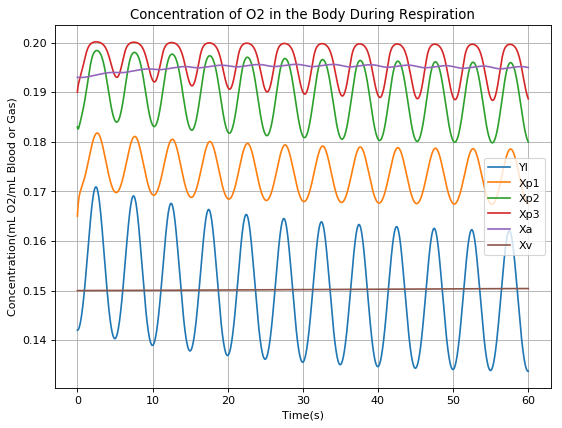

In [3]:
# Define function that will evaluate differential equations 
# at a given time, t.
# Array y is organized in the following order: y=[Yl,Xp1,Xp2,Xp3,Xa,Xv]
% matplotlib inline

def state(t,y,args):
    # Assign dependent variables
    Yl=y[0];Xa=y[4];Xv=y[5]
    
    # Account for discontinuity in Yj
    if y[1] < Xpjmax:
        Xp1=y[1]
    else:
        Xp1=0.201549 # As close as possible to Xpjmax
    if y[2] < Xpjmax:
        Xp2=y[2]
    else:
        Xp2=0.201549
    if y[3] < Xpjmax:
        Xp3=y[3]
    else:
        Xp3=0.201549
    
    Y1=Yj(Xp1);Y2=Yj(Xp2);Y3=Yj(Xp3)
    
    # Define and evaluate differential equations
    dYldt=1./Vl(t)*(Qa*Yair-Qa*Yl-Ka*(Yl-Y1)-Ka*(Yl-Y2)-Ka*(Yl-Y3)-Yl*dVldt(t))
    dXp1dt=1./Vp*(sigma*Qb*Xv+Ka*(Yl-Y1)-sigma*Qb*Xp1)
    dXp2dt=1./Vp*(sigma*Qb*Xp1+Ka*(Yl-Y2)-sigma*Qb*Xp2)
    dXp3dt=1./Vp*(sigma*Qb*Xp2+Ka*(Yl-Y3)-sigma*Qb*Xp3)
    dXadt=1./Va*((1-sigma)*Qb*Xv+sigma*Qb*Xp3-Qb*Xa)
    dXvdt=1./Vv*(Qb*Xa-Qb*Xv-M)
    
    #C reate array containing evaluated differential equations
    ddt=np.array([[dYldt,dXp1dt,dXp2dt,dXp3dt,dXadt,dXvdt]])
    return ddt




# Use 4th order runge-Kutta to integrate
#y=[Yl,Xp1,Xp2,Xp3,Xa,Xv]-> array y is organized in the preceding order


# Provide initial values (at t=0)of dependent variables
y0 = np.array([[0.142,0.165,0.183,0.190,0.193,0.150]])


# Assign tspan and stepsize
tspan = np.array([0.,60.]) #Span of 1 minute = 60 seconds
h = 0.01 #sec, (step size)
[t,y] = rk4sys(state,tspan,y0,h)


# Plot Results
labels=['Yl','Xp1','Xp2','Xp3','Xa','Xv']
pl.figure(num=None, figsize=(8, 6), dpi=80)
pl.grid(which='major',axis='both')
for n in range(6):
    pl.plot(t,y[:,n],label=labels[n])
    pl.xlabel('Time(s)')
    pl.ylabel('Concentration(mL O2/mL Blood or Gas)')
pl.legend(loc='best')   
pl.title('Concentration of O2 in the Body During Respiration')


   The concentration of O_2 oscillates in a sinusoidal fashion in all the compartments of the model except for the venous blood pool.  The concentration of O_2in the main lung compartment and the alveolar exchanges is particularly sensitive to the sinusoidal changes in the volume of the main lung compartment.  This sensitivity can be observed by noticing the large amplitude of the functions corresponding to these compartments.  Furthermore, the average value about which the functions are oscillating decreases and then stabilizes as t approaches 60 seconds.  
    
   On the other hand, the concentration of O_2 in the arterial and venous blood pools is better shielded from the oscillations in volume in the main lung compartment. The concentration in the arterial blood pool oscillates with a very relatively small amplitude; its average concentration increases from a time of 0 to 20 seconds and then stabilizes as t approaches 60 seconds.  The concentration in the venous blood pool does not exhibit any oscillatory behavior at all; the concentration of O_2 monotonically increases with time. 


## Average Concentration in the Lungs

In [7]:
# Calculate Average lung oxygen concentration, Yl, over 60 sec.
# Average= 1/60*integral of Yl from 0 to 60 sec

integralYl=cumtrapz(y[:,0],t) # y[:,0] corresponds to Yl
averageYl=1./60.*integralYl[-1] # use final value in interval
print 'Average Yl: {0:0.2f} ml O_2 / ml of blood.'.format(averageYl)


Average Yl: 0.15 ml O_2 / ml of blood.


The average concentration in the main lung compartment was calculated by integrating the Y_Lfunction using a cumulative trapezoidal method and then dividing by the interval of time, in this case 60 seconds.  The cumulative trapezoidal method is appropriate in this case because the stepsize is determined by the stepsize of the Runge-Kutta method originally used to produce the function.  With a sufficiently small step size, the frequent peaks of the Y_Lfunction should not greatly impact the accuracy of the method.  


## Behavior When Breath is Held for 60 Seconds

Text(0.5,1,u'Concentration of O2 in the Body While Holding Breath')

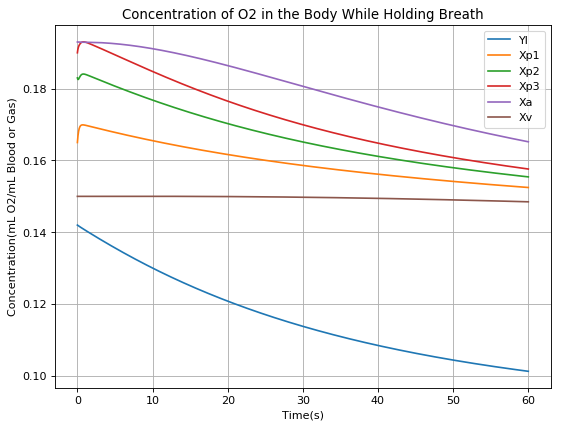

In [8]:
#Consider case where breathing stops at t=0
Qa=0. # ml air/s
Vl=2960. #ml (2960 mL at t=0)
dVldt=0. #ml/s
#Redefine function that evaluates differential equations 
def stateb(t,y,args):
    y=np.array(y.flat)
    #y=[Yl,Xp1,Xp2,Xp3,Xa,Xv]-> array y is organized in the preceding order
    #Assign dependent variables
    Yl=y[0];Xa=y[4];Xv=y[5]
    #Account for discontinuity in Yj
    if y[1] < Xpjmax:
        Xp1=y[1]
    else:
        Xp1=0.201549
    if y[2] < Xpjmax:
        Xp2=y[2]
    else:
        Xp2=0.201549
    if y[3] < Xpjmax:
        Xp3=y[3]
    else:
        Xp3=0.201549
    Y1=Yj(Xp1);Y2=Yj(Xp2);Y3=Yj(Xp3)
    #Define and evaluate differential equations
    dYldt=1/Vl*(-Ka*(Yl-Y1)-Ka*(Yl-Y2)-Ka*(Yl-Y3))
    dXp1dt=1./Vp*(sigma*Qb*Xv+Ka*(Yl-Y1)-sigma*Qb*Xp1)
    dXp2dt=1./Vp*(sigma*Qb*Xp1+Ka*(Yl-Y2)-sigma*Qb*Xp2)
    dXp3dt=1./Vp*(sigma*Qb*Xp2+Ka*(Yl-Y3)-sigma*Qb*Xp3)
    dXadt=1./Va*((1-sigma)*Qb*Xv+sigma*Qb*Xp3-Qb*Xa)
    dXvdt=1./Vv*(Qb*Xa-Qb*Xv-M)
    #Create array containing evaluated differential equations
    ddt=np.array([[dYldt,dXp1dt,dXp2dt,dXp3dt,dXadt,dXvdt]])
    return ddt
    
#Use Rk4 method to solve system
[t,y]=rk4sys(stateb,tspan,y0,h)   
#Plot new solution 
pl.figure(num=None, figsize=(8, 6), dpi=80)
pl.grid(which='major',axis='both')
for n in range(6):
    pl.plot(t,y[:,n],label=labels[n])
    pl.xlabel('Time(s)')
    pl.ylabel('Concentration(mL O2/mL Blood or Gas)')
pl.legend(loc='best')
pl.title('Concentration of O2 in the Body While Holding Breath')


If the volume of the main lung compartment is made constant, all of the concentration in the model exhibit a large decline over time, as the O_2in the system is consumed but not replenished by a new breath.  The steepness of the drop in concentration follows a pattern similar to that of the sensitivity to the oscillations discussed above.  The main lung compartment experiences the sharpest decline in O_2concentration.  The alveolar exchanges experience the next steepest drop, then the arterial blood pool, and finally the venous blood pool, which is again the least affected by the changes to the system in the lung compartment.  These trends are reasonable because it take time for any change in concentration ‘upfield’ to travel through the system and reach the ‘downfield’ compartment, the venous blood pool.  In other words, when the supply of O_2is suddenly cut off, the main lung compartment will be the first to register the change, while the existing O_2 in  the entire system will have to travel all the way to the venous blood pool to be consumed before a significant decline in O_2is registered there.

The differences in the concentration profiles of the two scenarios make sense. While most of the curves in the first case exhibit a sinusoidal behavior due to the breathing pattern of the person (i.e. air entering and exiting the lung), the curves in the second case are smooth and show a steady decline due to the air (and thus oxygen) intake cutoff as well as elimination of any sinusoidal terms.


## Time Necessary for O2 Concentration to Fall Below 75%

Percent Completed: 54.7453416149


Text(0.5,1,u'      Concentration of O2 in Arterial Blood While Holding Breath')

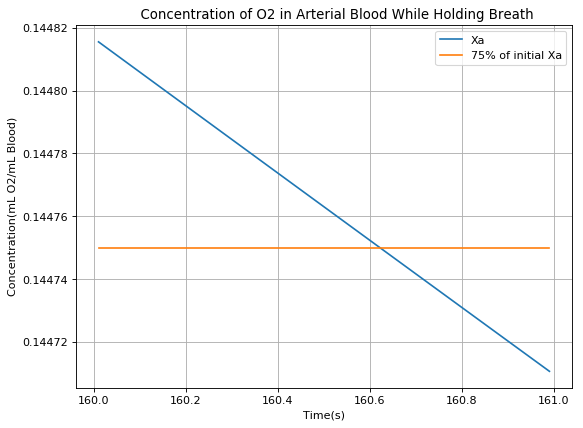

In [9]:
for i in range(len(t)):
    if (y[i,4] < .75*y[0,4]):
        print("It takes %f seconds"+\
        "for arterial blood oxygen concentration"+\
        "to reach 75% of initial value.",t[i])
        break
        
# Text in if statement is never pinted, which means 75%
# is not reached within 60 seconds.


# By trial and error, we found that it takes 160.5 sec for 
# arterial concentration to reach 0.75*0.193=0.14475 ml O2/ml blood


#Assign new tspan and stepsize
tspan=np.array([0.,161.])
h=0.01 #sec, (step size)
[t,y]=rk4sys(stateb,tspan,y0,h)


#Plot Results
pl.figure(num=None, figsize=(8, 6), dpi=80)
pl.grid(which='major',axis='both')
y75drop = zeros(len(t))+.75 * y0[0,4]
pl.plot(t[-100:-1],y[-100:-1,4],label='Xa')
pl.plot(t[-100:-1],y75drop[-100:-1],label='75% of initial Xa')
pl.xlabel('Time(s)')
pl.ylabel('Concentration(mL O2/mL Blood)')
pl.legend(loc='best')   
pl.title('      Concentration of O2 in Arterial Blood While Holding Breath')

